# Deep Embedding Clusteringを試してみたい

## 基本的なライブラリ・関数

In [1]:
# jupyter 関係
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# データ分析用
import pandas as pd
import numpy  as np
import random

# 機械学習用
import keras

# ファイル関係
import glob
import pickle
import json

# 描画関係
import matplotlib.pyplot as plt

# カラム全表示
pd.set_option('max_columns',None)

# 小数点の設定
%precision 5

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'%.5f'

## データの取得

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

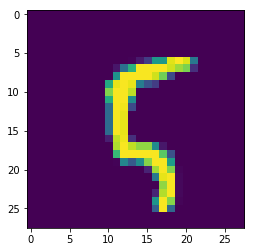

5


In [3]:
i = 100
plt.imshow(x_train[i])
plt.show()

print(y_train[i])

In [4]:
DATA_PATH = "data/"

with open(DATA_PATH+'mnist_images.pickle', 'wb') as f:
    mnist_images = np.r_[x_train, x_test]
    pickle.dump(mnist_images, f)

with open(DATA_PATH+'mnist_labels.pickle', 'wb') as f:
    mnist_labels = np.r_[y_train, y_test]
    pickle.dump(mnist_labels, f)

## StackedAutoEncoder

### 前準備

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# データの読み込み
with open(DATA_PATH+'mnist_images.pickle', 'rb') as f:
    mnist_images = pickle.load(f)
    mnist_images = mnist_images.reshape(mnist_images.shape[0], -1)
    mnist_images = mnist_images / 255.0

with open(DATA_PATH+'mnist_labels.pickle', 'rb') as f:
    mnist_labels = pickle.load(f)
    mnist_labels = mnist_labels.reshape(mnist_labels.shape[0], -1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mnist_images, mnist_labels, test_size=0.2, random_state=1000)

### モデル

In [8]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.initializers import glorot_normal

In [9]:
def StackedAutoEncoder(dims, dropout=True):
    '''
    dimsに従った次元を設定し長ならStackedAutoEncoder
    dims[0] : 入力次元
    '''
    input_data = Input(shape=(dims[0],), name="input")
    X = input_data
#     print("input : {}".format(X.shape))
    n_stack = len(dims) -1 
    initializer = glorot_normal(seed=10000)
    ### Encoder
    for i in range(n_stack):
        if i != n_stack - 1:
            # Stacked Encoder
            if dropout:
                X = Dense(dims[i+1], activation="relu", kernel_initializer=initializer, name="encoder_%d" % i)(X)
                X = Dropout(0.2)(X)
            else:
                X = Dense(dims[i+1], activation="relu", kernel_initializer=initializer, name="encoder_%d" % i)(X)
        else:
            # Encoded Features
            encoded = Dense(dims[i+1], kernel_initializer=initializer, name="encoded_features")(X)
            X = encoded
#         print("encoder_{} : {}".format(i, X.shape))

    ### Decoder
    for i in range(n_stack+1):
        if i != n_stack:
            # Stacked Decoder
            if dropout:
                X = Dense(dims[n_stack-i], activation="relu", kernel_initializer=initializer, name="decoder_%d" % i)(X)
                X = Dropout(0.2)(X)
            else:
                X = Dense(dims[n_stack-i], activation="relu", kernel_initializer=initializer, name="decoder_%d" % i)(X)
        else:
            # Reconstructed Data
            reconstructed = Dense(dims[n_stack-i], kernel_initializer=initializer, name="reconstructed_data")(X)
            X = reconstructed
#         print("decoder_{} : {}".format(i, X.shape))
    
    model = Model(input=input_data, output=reconstructed)

    return model

In [10]:
dims = [X_train.shape[-1], 500, 500, 2000, 10]
autoencoder = StackedAutoEncoder(dims)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2000)              0         
__________

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [11]:
# from keras.utils import plot_model
# plot_model(autoencoder, to_file="images/autoencoder.png", show_shapes=True)

# from IPython.display import Image
# Image(filename="images/autoencoder.png")

### 事前学習

In [31]:
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [32]:
# 学習率を少しずつ下げるようにする
def train(model, inputs, targets, X_val, Y_val, batch_size=100, epoch_count=100, 
              model_path="models/model.h5", learning_rate=0.01):
    # 学習率
    start = learning_rate
    stop = learning_rate * (1/epoch_count)
    learning_rates = np.linspace(start, stop, epoch_count)

    # 最適化手法
#     optimizer = Adam(lr=learning_rate)
    optimizer = SGD(lr=1, momentum=0.9)
    model.compile(loss="mse", optimizer=optimizer)

    # 学習
    fit = model.fit(inputs, targets, 
                        validation_data=(X_val, Y_val),
                        epochs=epoch_count,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
#                         callbacks=[LearningRateScheduler(lambda epoch: learning_rates[epoch]),]
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')]
                )

    # モデルの保存
    model.save(model_path)
    
    return fit

In [33]:
MODEL_PATH = "models/"
dims = [X_train.shape[-1], 500, 500, 2000, 10]
model = StackedAutoEncoder(dims)

fit = train(model, X_train, X_train, X_test, X_test, 200, 100, model_path=MODEL_PATH+"pre_ae_weights.h5")

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


Train on 56000 samples, validate on 14000 samples
Epoch 1/100
56000/56000 [==============================] - 16s 280us/step - loss: 0.0666 - val_loss: 0.0590
Epoch 2/100
56000/56000 [==============================] - 15s 264us/step - loss: 0.0569 - val_loss: 0.0530
Epoch 3/100
56000/56000 [==============================] - 15s 264us/step - loss: 0.0517 - val_loss: 0.0490
Epoch 4/100
56000/56000 [==============================] - 15s 263us/step - loss: 0.0492 - val_loss: 0.0475
Epoch 5/100
56000/56000 [==============================] - 15s 262us/step - loss: 0.0476 - val_loss: 0.0458
Epoch 6/100
56000/56000 [==============================] - 15s 266us/step - loss: 0.0461 - val_loss: 0.0445
Epoch 7/100
56000/56000 [==============================] - 15s 267us/step - loss: 0.0447 - val_loss: 0.0428
Epoch 8/100
56000/56000 [==============================] - 15s 268us/step - loss: 0.0434 - val_loss: 0.0412
Epoch 9/100
56000/56000 [==============================] - 15s 261us/step - loss: 0.04

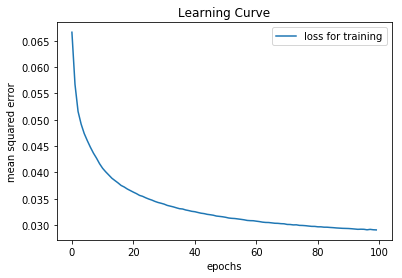

In [26]:
plt.plot(fit.history['loss'],label="loss for training")
plt.title("Learning Curve")
plt.xlabel("epochs")
plt.ylabel("mean squared error")
plt.legend()
plt.show()

# テストデータに対する精度
# ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
# accuracy_score(Y_test, np.round(ret))

In [28]:
from keras.models import load_model

In [29]:
model = load_model(MODEL_PATH+"pre_ae_weights.h5")

In [ ]:
def predict(comments, model_filepath="models/model.h5"):
    model = load_model(model_filepath)
    ret = model.predict(comments)
    return ret